# <font color=black>DATA 557 Homework 6</font>
***


In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats import anova
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df_sales = pd.read_csv("data/Sales_sample.csv")

In [21]:
pd.set_option('expand_frame_repr', False)
sns.set_style("darkgrid")

__1. Fit the linear regression model with sale price as response variable and SQFT, LOT_SIZE, BEDS, and 
BATHS as predictor variables (Model 1 from HW 5). Calculate robust standard errors for the coefficient 
estimates. Display a table with estimated coefficients, the usual standard errors that assume constant 
variance, and robust standard errors.__

In [20]:
full_model = ols('LAST_SALE_PRICE ~ SQFT + LOT_SIZE + BEDS + BATHS', data=df_sales).fit()
full_model_robust = ols('LAST_SALE_PRICE ~ SQFT + LOT_SIZE + BEDS + BATHS', data=df_sales).fit(cov_type='HC3')

d = [full_model.params.values,full_model.bse.values,full_model_robust.bse.values]
df = pd.DataFrame(d,columns=['Intercept','SQFT','LOT_SIZE','BEDS','BATHS'])
df['Value'] = ['Estimated Coeffcients','Usual Standard Errors','Robust Standard Errors']
df = df[['Value','Intercept','SQFT','LOT_SIZE','BEDS','BATHS']]
print(df)

                    Value     Intercept        SQFT  LOT_SIZE          BEDS          BATHS
0   Estimated Coeffcients   5982.604259  224.502066  6.844143 -60884.742104  178177.446061
1   Usual Standard Errors  40023.271418   14.793972  1.857731  14461.536156   17107.531726
2  Robust Standard Errors  49655.792470   24.394722  7.734398  17255.919552   22796.269233


__2. Which set of standard errors should be used? Explain by referring to HW 5.__

In HW5, we discerned that the constant variance error was violated. <br>
Since Linear Regression requires homoscedasticity but this is not needed when using robust standard errors for Linear Regression.  <br>
Therefore, since Robust Standard Errors accomodates the heteroscedasticity, it is more appropriate for this model.

__3. Perform the Wald test for testing that the coefficient of the LOT_SIZE variable is equal to 0. Use the usual 
standard errors that assume constant variance. Report the test statistic and p-value.__

The full model : <br>
<center> LAST_SALE_PRICE = β<sub>0</sub> + β<sub>1</sub> * SQFT + β<sub>2</sub> * LOT_SIZE + β<sub>3</sub> * BEDS + β<sub>4</sub> * BATHS </center>

We can define the null hypothesis as : <br>
<center> H0 : β<sub>2</sub> = 0  <br></center>

Hence, our reduced model is : <br>
<center> LAST_SALE_PRICE = β<sub>0</sub> + β<sub>1</sub> * SQFT + β<sub>3</sub> * BEDS + β<sub>4</sub> * BATHS </center>

In [10]:
red_model = ols('LAST_SALE_PRICE ~ SQFT + BEDS + BATHS', data=df_sales).fit()
anovaResults = anova_lm(red_model, full_model)
f_statistic = anovaResults.values[1][4]

print('\033[1m'+"Using the F test:\nF statistic : %f"%(f_statistic))
p = 1-stats.f.cdf(f_statistic, 1, 995)
print("p value : "f'{p:.20f}')

waldResults = full_model.wald_test('(LOT_SIZE=0)')
print('\033[1m'+"\n\nUsing wald test:\nwald statistic : %f\np value : %f"%(waldResults.statistic,waldResults.pvalue))

Using the F test:
F statistic : 13.572897
p value : 0.00024184177093033998


Using wald test:
wald statistic : 13.572897
p value : 0.000242


__4. Perform the robust Wald test statistic for testing that the coefficient of the LOT_SIZE variable is equal to 0. 
Report the test statistic and p-value.__

In [14]:
waldResults = full_model_robust.wald_test('(LOT_SIZE=0)')
print('\033[1m'+"Wald Test:\nwald statistic : %f\np value : %f"%(waldResults.statistic,waldResults.pvalue))

Wald Test:
wald statistic : 0.783042
p value : 0.376212


__5. Use the jackknife to estimate the SE for the coefficient of the LOT_SIZE variable. Report the jackknife 
estimate of the SE.__

Jankknife estimate for Standard Error : 7.726589


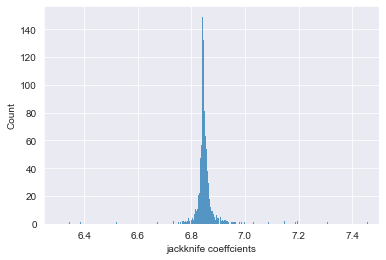

In [22]:
n = len(df_sales)
jack_coeffs = []
for i in range(n):
    df = df_sales[~(df_sales.index==i)]
    full_m = ols('LAST_SALE_PRICE ~ SQFT + LOT_SIZE + BEDS + BATHS', data=df).fit()
    jack_coeffs.append(full_m.params['LOT_SIZE'])
sns.histplot(jack_coeffs)
plt.xlim(6.25,7.5)
plt.xlabel("jackknife coeffcients")
jack_SE = (n-1) * np.std(jack_coeffs) / n**0.5
print('\033[1m'+"Jankknife estimate for Standard Error : %f"%(jack_SE))

__6. Use the jackknife estimate of the SE to test the null hypothesis that the coefficient of the LOT_SIZE 
variable is equal to 0. Report the test statistic and p-value.__

In [56]:
test_statistic = full_model.params['LOT_SIZE']/jack_SE
print('\033[1m'+"Test statistic : %f"%(test_statistic))
p = stats.t.sf(abs(test_statistic), df=995)*2
print("p value : "f'{p:.20f}')

Test statistic : 0.885791
p value : 0.37594416603280977895


__7.Do the tests in Q3, Q4, and Q6 agree? Which of these tests are valid?__

Q3 : p valuue using Wald test with regular SE's - 0.000242<br>
Q4 : p valuue using Wald test with regular SE's - 0.376212<br>
Q7 : p valuue using Wald test with regular SE's - 0.375944<br>

We see that the p value is drastically different for Q3 whereas Q4 and Q5 are extremely similar.<br>
Under a 0.05 significance level, we would reject the null hypothesis in Q3 but not Q4 or Q5. <br>
Since Q3 did not accomodate for the apparent heteroscedasticity in the model. Hence, the statistical inferences from Q4 and Q5 would be more appropriate as both Jackknife and Robust SE's can be used when constant variance assumption is violated.

__8. Remove the LOT_SIZE variable from Model 1 (call this Model 1A). Fit Model 1A and report the table of 
coefficients, the usual standard errors that assume constant variance, and robust standard errors.__

In [31]:
model_1a_robust = ols('LAST_SALE_PRICE ~ SQFT + BEDS + BATHS', data=df_sales).fit(cov_type='HC3')
model_1a = ols('LAST_SALE_PRICE ~ SQFT + BEDS + BATHS', data=df_sales).fit()

d = [model_1a.params.values,model_1a.bse.values,model_1a_robust.bse.values]
df = pd.DataFrame(d,columns=['Intercept','SQFT','BEDS','BATHS'])
df['Value'] = ['Estimated Coeffcients','Usual Standard Errors','Robust Standard Errors']
df = df[['Value','Intercept','SQFT','BEDS','BATHS']]
print(df)

                    Value     Intercept        SQFT          BEDS          BATHS
0   Estimated Coeffcients  29034.457704  234.041806 -59374.556347  176027.854308
1   Usual Standard Errors  39779.873137   14.657241  14546.679416   17205.155129
2  Robust Standard Errors  43389.508486   27.365704  16282.834910   22791.626582


__9. Add the square of the LOT_SIZE variable to Model 1 (call this Model 1B). Fit Model 1B and report the 
table of coefficients, the usual standard errors that assume constant variance, and robust standard errors.__

In [30]:
model_1b_robust = ols('LAST_SALE_PRICE ~ SQFT + LOT_SIZE + np.power(LOT_SIZE, 2) + BEDS + BATHS', data=df_sales).fit(cov_type='HC3')
model_1b = ols('LAST_SALE_PRICE ~ SQFT + LOT_SIZE + np.power(LOT_SIZE, 2) + BEDS + BATHS', data=df_sales).fit()

d = [model_1b.params.values,model_1b.bse.values,model_1b_robust.bse.values]
df = pd.DataFrame(d,columns=['Intercept','SQFT','LOT_SIZE','LOT_SIZE^2','BEDS','BATHS'])
df['Value'] = ['Estimated Coeffcients','Usual Standard Errors','Robust Standard Errors']
df = df[['Value','Intercept','SQFT','LOT_SIZE','LOT_SIZE^2','BEDS','BATHS']]
print(df)

                    Value     Intercept        SQFT   LOT_SIZE  LOT_SIZE^2          BEDS          BATHS
0   Estimated Coeffcients  98703.527600  228.141375 -17.040539    0.000467 -48502.615655  168809.711947
1   Usual Standard Errors  41352.692737   14.467833   3.904434    0.000068  14246.499063   16774.174327
2  Robust Standard Errors  69639.758566   24.665583  11.141494    0.000326  15612.725844   24697.178819


__10. Perform the F test to compare Model 1A and Model 1B. Report the p-value.__

In [60]:
anovaResults = anova_lm(model_1a, model_1b)
f_statistic = anovaResults.values[1][4]
print('\033[1m'+"F statistic : %f"%(f_statistic))
p = 1-stats.f.cdf(f_statistic, 2, 994)
print("p value : "f'{p:.20f}')

F statistic : 30.978052
p value : 0.00000000000008892886


__11. State the null hypothesis being tested in Q10 either in words or by using model formulas.__

The full model (Model 1B) : <br>
<center> LAST_SALE_PRICE = β<sub>0</sub> + β<sub>1</sub> * SQFT + β<sub>2</sub> * LOT_SIZE + β<sub>3</sub> * LOT_SIZE^2 + β<sub>4</sub> * BEDS + β<sub>5</sub> * BATHS </center>

We can define the null hypothesis as : <br>
<center> H0 : β<sub>2</sub> = β<sub>3</sub> = 0  <br></center>

Hence, our reduced model is (Model 1A) : <br>
<center> LAST_SALE_PRICE = β<sub>0</sub> + β<sub>1</sub> * SQFT + β<sub>3</sub> * BEDS + β<sub>4</sub> * BATHS </center>

__12. Perform the robust Wald test to compare Model 1A and Model 1B. Report the p-value.__

In [62]:
waldResults = model_1b_robust.wald_test('(LOT_SIZE=0,np.power(LOT_SIZE, 2)=0 )')
print('\033[1m'+"Robust Wald Test:\nwald statistic : {}\np value : {}".format(waldResults.statistic,waldResults.pvalue))

Robust Wald Test:
wald statistic : [[2.33967489]]
p value : 0.31041739721360595


__13. Compare the results of the tests in Q10 and Q12. Which test is valid?__

Text(0, 0.5, 'Residuals')

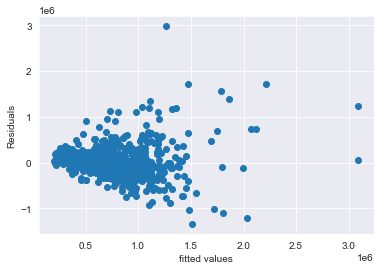

In [64]:
plt.scatter(x=model_1b.fittedvalues, y = model_1b.resid)
plt.xlabel("fitted values")
plt.ylabel("Residuals")

Q10 : p value from F test - 0.00000000000008892886 <br>
Q12 : p value from robust Wald Test - 0.3104 <br>

These p values are extremely different, assuming a 0.05 significance level <br>
We would reject the null hypothesis in Q10 but we do not have enough evidece to do so in Q12. Since there is a presence of heteroscedasticity in the model, Q12 would be more appropriate to make statistical inferences.

__The following questions use the LOG_PRICE variable as in HW 5. Fit models corresponding to Model 1A and 
Model 1B with LOG_PRICE as the response variable. Call these models Model 1A_Log and Model 1B_Log.__

In [46]:
df_sales['LOG_PRICE'] = np.log10(df_sales['LAST_SALE_PRICE'])

__14. Perform the F test to compare Model 1A_Log and Model 1B_Log. Report the p-value.__

In [47]:
full_model1a_log = ols('LOG_PRICE ~ SQFT + BEDS + BATHS', data=df_sales).fit()
full_model1b_log = ols('LOG_PRICE ~ SQFT + LOT_SIZE + np.power(LOT_SIZE, 2) + BEDS + BATHS', data=df_sales).fit()
anovaResults = anova_lm(full_model1a_log, full_model1b_log)
f_statistic = anovaResults.values[1][4]
print('\033[1m'+"F statistic : %f"%(f_statistic))
p = 1-stats.f.cdf(f_statistic, 2, 994)
print("p value : "f'{p:.20f}')

F statistic : 27.617701
p value : 0.00000000000212418971


__15. State the null hypothesis being tested in Q14 either in words or by using model formulas.__

The full model (Model 1B_Log) : <br>
<center> LOG<sub>10</sub>(LAST_SALE_PRICE) = β<sub>0</sub> + β<sub>1</sub> * SQFT + β<sub>2</sub> * LOT_SIZE + β<sub>3</sub> * LOT_SIZE^2 + β<sub>4</sub> * BEDS + β<sub>5</sub> * BATHS </center>

We can define the null hypothesis as : <br>
<center> H0 : β<sub>2</sub> = β<sub>3</sub> = 0  <br></center>

Hence, our reduced model is (Model 1A_log) : <br>
<center> LOG<sub>10</sub>(LAST_SALE_PRICE) = β<sub>0</sub> + β<sub>1</sub> * SQFT + β<sub>3</sub> * BEDS + β<sub>4</sub> * BATHS </center>

__16. Perform the robust Wald test to compare Model 1A_Log and Model 1B_Log. Report the p-value.__

In [50]:
full_model1b_log_robust = ols('LOG_PRICE ~ SQFT + LOT_SIZE + np.power(LOT_SIZE, 2) + BEDS + BATHS', data=df_sales).fit(cov_type='HC3')
waldResults = full_model1b_log_robust.wald_test('(LOT_SIZE=0,np.power(LOT_SIZE, 2)=0 )')

scientific_notation = "{:.2e}".format(waldResults.pvalue)
print('\033[1m'+"Wald Test:\nwald statistic : {}\np value : {}".format(waldResults.statistic,scientific_notation))


Wald Test:
wald statistic : [[44.08152396]]
p value : 2.68e-10


__17. Compare the results of the tests in Q14 and Q16. Do they give the same conclusion?__

Text(0, 0.5, 'Residuals')

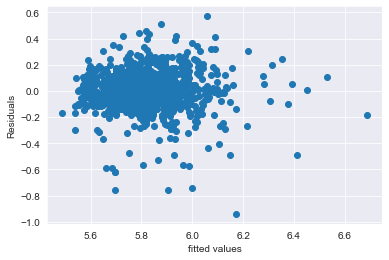

In [65]:
plt.scatter(x=full_model1b_log.fittedvalues, y = full_model1b_log.resid)
plt.xlabel("fitted values")
plt.ylabel("Residuals")

Q14 : p value from F test - 2.12e-12<br>
Q15 : p value from robust wald test - 2.68e-10<br>

These p values are similar and we would reach the same conclusion at a 0.05 significance level to reject the null hypothesis. 

__18. Based on all of the analyses performed, answer the following question. Is there evidence for an 
association between the size of the lot and sales price? Explain.__

In this assignment, we looked at the linear, quadratic relationship of LOT_SIZE with the regular and log values of sale price. <br>
We used robust SE's and jackknife to account for heteroscedasticity that was present in the model so we can make valid statistical inferences. <br>
Therefore, after accounting for the heteroscedasticity and taking log for sale price we see that __there is not enough evidence to reject the null hypothesis, indicating that there is an association between LOT_SIZE and LAST_SALE_PRICE.__ 